# Modelos Tradicionales con Winsorizing

**Objetivo**: Cambiar que algunas columnas como `favourites`, `retweets` y `followers_count` aún presentaban valores absolutos máximos extremadamente altos después del escalado. Estos outliers residuales, aunque menos influyentes que antes, todavía pueden sesgar el entrenamiento de algunos modelos y afectar su rendimiento.

Aplicare la técnica de **Winsorizing**. Esta técnica no elimina los valores atípicos, sino que los "acota" o "limita" a un cierto percentil. Por ejemplo, si establecemos límites del 1% y 99%, todos los valores por debajo del percentil 1 se reemplazarán por el valor del percentil 1, y todos los valores por encima del percentil 99 se reemplazarán por el valor del percentil 99. Esto permite que los valores extremos sigan siendo parte del dataset, pero con una influencia reducida, preservando la distribución general de los datos.

In [3]:
# Importaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Plotly para visualizaciones interactivas
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Machine learning
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                           roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import StandardScaler

# Para guardar resultados
import joblib
import json
import os

# Para manejo avanzado de outliers
from scipy.stats.mstats import winsorize

print(f"Iniciando experimentos con modelos tradicionales - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Iniciando experimentos con modelos tradicionales - 2025-08-19 19:36:21


In [4]:
# Cargar datos procesados si df no está definido
df = pd.read_csv('../processed_data/dataset_features_processed.csv')

# Columnas identificadas con outliers extremos en la Fase 0 (según el output del notebook 02)
cols_with_extreme_outliers = ['favourites', 'retweets', 'followers_count', 'BotScoreBinary', 'BotScore', 'WORK_OF_ART_percentage', 'TIME_percentage', 'NORP_percentage', 'LAW_percentage', 'PERCENT_percentage', 'PRODUCT_percentage', 'ORDINAL_percentage', 'LOC_percentage']

print("- Winsorizing a columnas con outliers extremos...")

df_winsorized = df.copy()

for col in cols_with_extreme_outliers:
    if col in df_winsorized.columns:
        # Aplicar winsorize al 1% inferior y 1% superior
        df_winsorized[col] = winsorize(df_winsorized[col], limits=[0.01, 0.01])
        print(f"  - Winsorizing aplicado a '{col}'")
    else:
        print(f"  - Columna '{col}' no encontrada para Winsorizing.")

print("- Winsorizing completado.")

print("- Comparación de estadísticas (antes vs después de Winsorizing) para columnas clave:")
for col in ['favourites', 'retweets', 'followers_count']:
    if col in df.columns:
        print(f"--- Columna: {col} ---")
        print("Original (Max):", df[col].max())
        print("Winsorized (Max):", df_winsorized[col].max())
        print("Original (Min):", df[col].min())
        print("Winsorized (Min):", df_winsorized[col].min())
        print("\n")

# Guardar el dataset con Winsorizing aplicado
output_path_winsorized = '../processed_data/dataset_features_processed_winsorized.csv'
os.makedirs(os.path.dirname(output_path_winsorized), exist_ok=True)
df_winsorized.to_csv(output_path_winsorized, index=False)
print(f"- Dataset con Winsorizing guardado en: {output_path_winsorized}")

- Winsorizing a columnas con outliers extremos...
  - Winsorizing aplicado a 'favourites'
  - Winsorizing aplicado a 'retweets'
  - Winsorizing aplicado a 'followers_count'
  - Winsorizing aplicado a 'BotScoreBinary'
  - Winsorizing aplicado a 'BotScore'
  - Winsorizing aplicado a 'WORK_OF_ART_percentage'
  - Winsorizing aplicado a 'TIME_percentage'
  - Winsorizing aplicado a 'NORP_percentage'
  - Winsorizing aplicado a 'LAW_percentage'
  - Winsorizing aplicado a 'PERCENT_percentage'
  - Winsorizing aplicado a 'PRODUCT_percentage'
  - Winsorizing aplicado a 'ORDINAL_percentage'
  - Winsorizing aplicado a 'LOC_percentage'
- Winsorizing completado.
- Comparación de estadísticas (antes vs después de Winsorizing) para columnas clave:
--- Columna: favourites ---
Original (Max): 460320.0
Winsorized (Max): 128.0
Original (Min): 0.0
Winsorized (Min): 0.0


--- Columna: retweets ---
Original (Max): 126062.0
Winsorized (Max): 35.0
Original (Min): 0.0
Winsorized (Min): 0.0


--- Columna: follower

In [5]:
# Cargar datos procesados
print("Cargando datos procesados...")

df = pd.read_csv('../processed_data/dataset_features_processed_winsorized.csv')
print(f"Dataset cargado: {df.shape[0]:,} filas, {df.shape[1]} columnas")

# Separar features y target
X = df.drop('BinaryNumTarget', axis=1)
y = df['BinaryNumTarget']

print(f"Features: {X.shape[1]}")
print(f"Distribución de clases:")
class_dist = y.value_counts(normalize=True)
for clase, prop in class_dist.items():
    label = "Falso" if clase == 0 else "Verdadero"
    print(f"  {label}: {prop:.3f} ({y.value_counts()[clase]:,} muestras)")

# Verificar que no hay valores faltantes
missing = X.isnull().sum().sum()
print(f"Valores faltantes: {missing}")

# Mostrar algunas estadísticas básicas
print(f"\nRango de valores en X:")
print(f"  Mínimo: {X.min().min():.3f}")
print(f"  Máximo: {X.max().max():.3f}")
print(f"  Media general: {X.mean().mean():.3f}")

# Visualización interactiva de la distribución de clases
fig_clases = px.pie(
    values=y.value_counts().values,
    names=['Falso', 'Verdadero'],
    title="Distribución de Clases en el Dataset",
    color_discrete_sequence=['lightcoral', 'lightblue']
)
fig_clases.show()

# Visualización de estadísticas básicas de features
stats_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean': X.mean(),
    'Std': X.std(),
    'Min': X.min(),
    'Max': X.max()
}).reset_index(drop=True)

# Gráfico interactivo de estadísticas
fig_stats = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Media por Feature', 'Desviación Estándar', 'Valores Mínimos', 'Valores Máximos'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Media
fig_stats.add_trace(
    go.Scatter(x=list(range(len(stats_df))), y=stats_df['Mean'], 
               mode='markers', name='Media', showlegend=False),
    row=1, col=1
)

# Std
fig_stats.add_trace(
    go.Scatter(x=list(range(len(stats_df))), y=stats_df['Std'], 
               mode='markers', name='Std', showlegend=False, marker_color='orange'),
    row=1, col=2
)

# Min
fig_stats.add_trace(
    go.Scatter(x=list(range(len(stats_df))), y=stats_df['Min'], 
               mode='markers', name='Min', showlegend=False, marker_color='red'),
    row=2, col=1
)

# Max
fig_stats.add_trace(
    go.Scatter(x=list(range(len(stats_df))), y=stats_df['Max'], 
               mode='markers', name='Max', showlegend=False, marker_color='green'),
    row=2, col=2
)

fig_stats.update_layout(
    title="Estadísticas Descriptivas de Features",
    height=600,
    showlegend=False
)
fig_stats.show()

Cargando datos procesados...
Dataset cargado: 134,198 filas, 58 columnas
Features: 57
Distribución de clases:
  Verdadero: 0.514 (68,930 muestras)
  Falso: 0.486 (65,268 muestras)
Valores faltantes: 0

Rango de valores en X:
  Mínimo: -7.110
  Máximo: 42068.000
  Media general: 0.446


In [6]:
# Cargar datos procesados
print("Cargando datos procesados...")

df = pd.read_csv('../processed_data/dataset_features_processed_winsorized.csv')
print(f"Dataset cargado: {df.shape[0]:,} filas, {df.shape[1]} columnas")

# Separar features y target
X = df.drop('BinaryNumTarget', axis=1)
y = df['BinaryNumTarget']

print(f"Features: {X.shape[1]}")
print(f"Distribución de clases:")
class_dist = y.value_counts(normalize=True)
for clase, prop in class_dist.items():
    label = "Falso" if clase == 0 else "Verdadero"
    print(f"  {label}: {prop:.3f} ({y.value_counts()[clase]:,} muestras)")

# Verificar que no hay valores faltantes
missing = X.isnull().sum().sum()
print(f"Valores faltantes: {missing}")

# Mostrar algunas estadísticas básicas
print(f"\nRango de valores en X:")
print(f"  Mínimo: {X.min().min():.3f}")
print(f"  Máximo: {X.max().max():.3f}")
print(f"  Media general: {X.mean().mean():.3f}")

Cargando datos procesados...
Dataset cargado: 134,198 filas, 58 columnas
Features: 57
Distribución de clases:
  Verdadero: 0.514 (68,930 muestras)
  Falso: 0.486 (65,268 muestras)
Valores faltantes: 0

Rango de valores en X:
  Mínimo: -7.110
  Máximo: 42068.000
  Media general: 0.446


## Configuración de validación cruzada

Voy a usar validación cruzada estratificada de 5 folds. Esto es importante porque:
- Mantiene la proporción de clases en cada fold
- Me da una estimación más robusta del rendimiento
- Reduce la variabilidad por división aleatoria de datos

Voy a evaluar con F1-score como métrica principal porque es una buena métrica balanceada para clasificación binaria.

In [7]:
# Configurar validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'f1'  # F1-score como métrica principal

# También voy a calcular otras métricas para comparar
scoring_metrics = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc']

print(f"Configuración de validación cruzada:")
print(f"  - Método: StratifiedKFold")
print(f"  - Folds: 5")
print(f"  - Métrica principal: F1-score")
print(f"  - Métricas adicionales: {', '.join(scoring_metrics)}")
print(f"  - Random state: 42")

Configuración de validación cruzada:
  - Método: StratifiedKFold
  - Folds: 5
  - Métrica principal: F1-score
  - Métricas adicionales: f1, precision, recall, accuracy, roc_auc
  - Random state: 42


## Función para evaluar modelos

Voy a crear una función que me permita evaluar cualquier modelo de forma consistente. Esto me va a ahorrar código repetitivo y asegurar que todos los modelos se evalúen igual.

In [8]:
def evaluar_modelo(modelo, X, y, cv, nombre_modelo):
    """
    Evalúa un modelo usando validación cruzada.
    
    Parámetros:
    - modelo: modelo de sklearn ya configurado
    - X, y: datos de entrada y target
    - cv: objeto de validación cruzada
    - nombre_modelo: string para identificar el modelo
    
    Retorna:
    - dict con resultados de todas las métricas
    """
    print(f"\nEvaluando {nombre_modelo}...")
    
    resultados = {}
    
    # Calcular cada métrica
    for metric in scoring_metrics:
        scores = cross_val_score(modelo, X, y, cv=cv, scoring=metric, n_jobs=-1)
        resultados[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores.tolist()
        }
        print(f"  {metric}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    # Guardar configuración del modelo
    resultados['modelo'] = nombre_modelo
    resultados['parametros'] = modelo.get_params()
    resultados['timestamp'] = datetime.now().isoformat()
    
    return resultados

## Random Forest

Empiezo con Random Forest porque es un algoritmo muy robusto que suele funcionar bien out-of-the-box. 

Configuración que voy a usar:
- 100 árboles (balance entre rendimiento y velocidad)
- max_depth=15 (evitar overfitting extremo)
- class_weight='balanced' (compensar cualquier desbalance)
- Otros parámetros por defecto de sklearn

In [9]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_resultados = evaluar_modelo(rf_model, X, y, cv, "Random Forest")


Evaluando Random Forest...
  f1: 0.6773 (+/- 0.0075)
  precision: 0.7110 (+/- 0.0122)
  recall: 0.6468 (+/- 0.0072)
  accuracy: 0.6835 (+/- 0.0087)
  roc_auc: 0.7524 (+/- 0.0080)


## Decision Tree

Un árbol de decisión individual me va a dar una línea base más simple. Es útil para entender si la complejidad de Random Forest realmente aporta valor.

In [10]:
# Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

dt_resultados = evaluar_modelo(dt_model, X, y, cv, "Decision Tree")


Evaluando Decision Tree...
  f1: 0.6224 (+/- 0.0089)
  precision: 0.6586 (+/- 0.0049)
  recall: 0.5900 (+/- 0.0150)
  accuracy: 0.6323 (+/- 0.0053)
  roc_auc: 0.6839 (+/- 0.0043)


## Extra Trees

Extra Trees es similar a Random Forest pero con más aleatoriedad en la selección de splits. A veces puede funcionar mejor que RF, especialmente con features ruidosas.

In [11]:
# Extra Trees
et_model = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

et_resultados = evaluar_modelo(et_model, X, y, cv, "Extra Trees")


Evaluando Extra Trees...
  f1: 0.6410 (+/- 0.0065)
  precision: 0.6802 (+/- 0.0104)
  recall: 0.6062 (+/- 0.0088)
  accuracy: 0.6513 (+/- 0.0072)
  roc_auc: 0.7088 (+/- 0.0064)


## Logistic Regression

Regresión logística es importante como baseline linear. Me va a decir qué tan bien se pueden separar las clases con un modelo simple.

Nota: Los datos ya están escalados, así que no necesito hacer scaling adicional.

In [12]:
# Logistic Regression
lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

lr_resultados = evaluar_modelo(lr_model, X, y, cv, "Logistic Regression")


Evaluando Logistic Regression...
  f1: 0.6409 (+/- 0.0085)
  precision: 0.6531 (+/- 0.0099)
  recall: 0.6292 (+/- 0.0094)
  accuracy: 0.6379 (+/- 0.0089)
  roc_auc: 0.6902 (+/- 0.0091)


## K-Nearest Neighbors

KNN es útil como contraste porque es un método no paramétrico que puede capturar relaciones no lineales complejas. Voy a probar con k=5 como punto de partida.

In [14]:
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    metric='minkowski',
    n_jobs=-1
)

knn_resultados = evaluar_modelo(knn_model, X, y, cv, "K-Nearest Neighbors")


Evaluando K-Nearest Neighbors...
  f1: 0.6395 (+/- 0.0065)
  precision: 0.6342 (+/- 0.0043)
  recall: 0.6448 (+/- 0.0104)
  accuracy: 0.6265 (+/- 0.0051)
  roc_auc: 0.6735 (+/- 0.0058)


## Comparación de resultados

Ahora voy a compilar todos los resultados en una tabla para poder compararlos fácilmente.

In [15]:
# Recopilar todos los resultados
todos_resultados = {
    'Random Forest': rf_resultados,
    'Decision Tree': dt_resultados,
    'Extra Trees': et_resultados,
    'Logistic Regression': lr_resultados,
    'K-Nearest Neighbors': knn_resultados
}

# Crear tabla de comparación
tabla_comparacion = []

for nombre, resultado in todos_resultados.items():
    fila = {
        'Modelo': nombre,
        'F1-Score': resultado['f1']['mean'],
        'F1-Std': resultado['f1']['std'],
        'Precision': resultado['precision']['mean'],
        'Recall': resultado['recall']['mean'],
        'Accuracy': resultado['accuracy']['mean'],
        'ROC-AUC': resultado['roc_auc']['mean']
    }
    tabla_comparacion.append(fila)

# Convertir a DataFrame y ordenar por F1-Score
df_comparacion = pd.DataFrame(tabla_comparacion)
df_comparacion = df_comparacion.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("RESUMEN DE RESULTADOS - MODELOS TRADICIONALES CON WINSORIZING")
print("="*80)

# Mostrar tabla formateada
print(f"\n{'Modelo':<20} {'F1-Score':<10} {'Precision':<10} {'Recall':<10} {'Accuracy':<10} {'ROC-AUC':<10}")
print("-" * 80)

for _, row in df_comparacion.iterrows():
    print(f"{row['Modelo']:<20} {row['F1-Score']:<10.4f} {row['Precision']:<10.4f} {row['Recall']:<10.4f} {row['Accuracy']:<10.4f} {row['ROC-AUC']:<10.4f}")

# Identificar el mejor modelo
mejor_modelo = df_comparacion.iloc[0]
print(f"\nMejor modelo: {mejor_modelo['Modelo']} (F1-Score: {mejor_modelo['F1-Score']:.4f})")


RESUMEN DE RESULTADOS - MODELOS TRADICIONALES CON WINSORIZING

Modelo               F1-Score   Precision  Recall     Accuracy   ROC-AUC   
--------------------------------------------------------------------------------
Random Forest        0.6773     0.7110     0.6468     0.6835     0.7524    
Extra Trees          0.6410     0.6802     0.6062     0.6513     0.7088    
Logistic Regression  0.6409     0.6531     0.6292     0.6379     0.6902    
K-Nearest Neighbors  0.6395     0.6342     0.6448     0.6265     0.6735    
Decision Tree        0.6224     0.6586     0.5900     0.6323     0.6839    

Mejor modelo: Random Forest (F1-Score: 0.6773)


## Análisis de importancia de features

Para los modelos basados en árboles, voy a extraer la importancia de features. Esto me va a ayudar a entender qué características son más útiles para la clasificación.

Analizando importancia de features con Random Forest...

Top 15 features más importantes:
--------------------------------------------------
 1. listed_count              0.0688
 2. PERSON_percentage         0.0446
 3. favourites_count          0.0404
 4. Average word length       0.0396
 5. normalize_influence       0.0393
 6. Word count                0.0391
 7. followers_count           0.0389
 8. capitals                  0.0368
 9. statuses_count            0.0367
10. cred                      0.0359
11. URLs                      0.0354
12. friends_count             0.0322
13. short_word_freq           0.0289
14. hashtags                  0.0256
15. past_verbs                0.0249


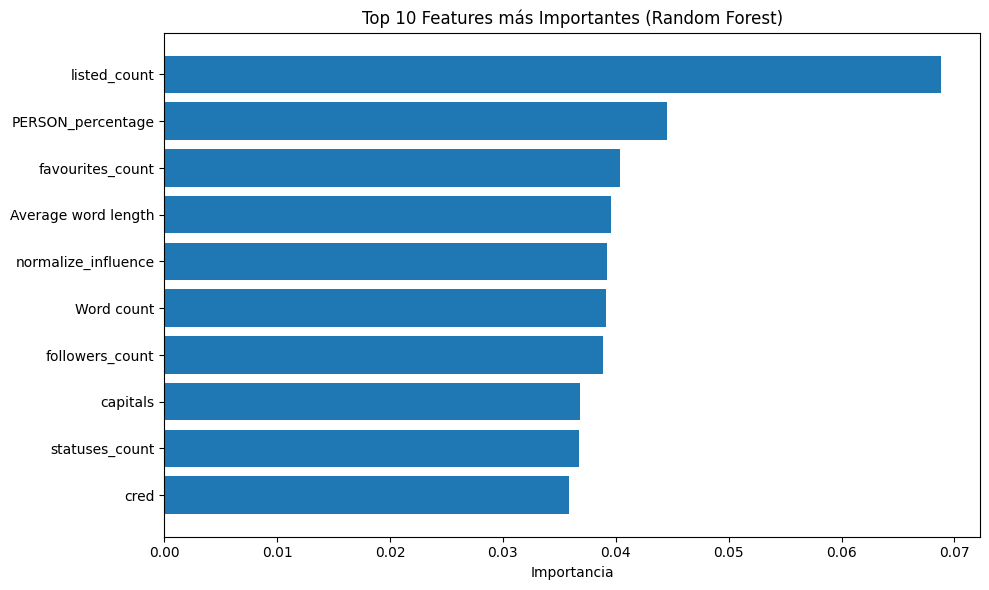


Número de features que explican 80% de la importancia: 26


In [16]:
# Entrenar Random Forest en todos los datos para obtener importancia de features
print("Analizando importancia de features con Random Forest...")

rf_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_full.fit(X, y)

# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_full.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 features más importantes:")
print("-" * 50)
for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Visualizar top 10
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 10 Features más Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Calcular importancia acumulada
feature_importance['importancia_acumulada'] = feature_importance['importance'].cumsum()
features_80_pct = feature_importance[feature_importance['importancia_acumulada'] <= 0.8]
print(f"\nNúmero de features que explican 80% de la importancia: {len(features_80_pct)}")

## Visualización de resultados

Voy a crear algunas visualizaciones para entender mejor cómo se comparan los modelos.

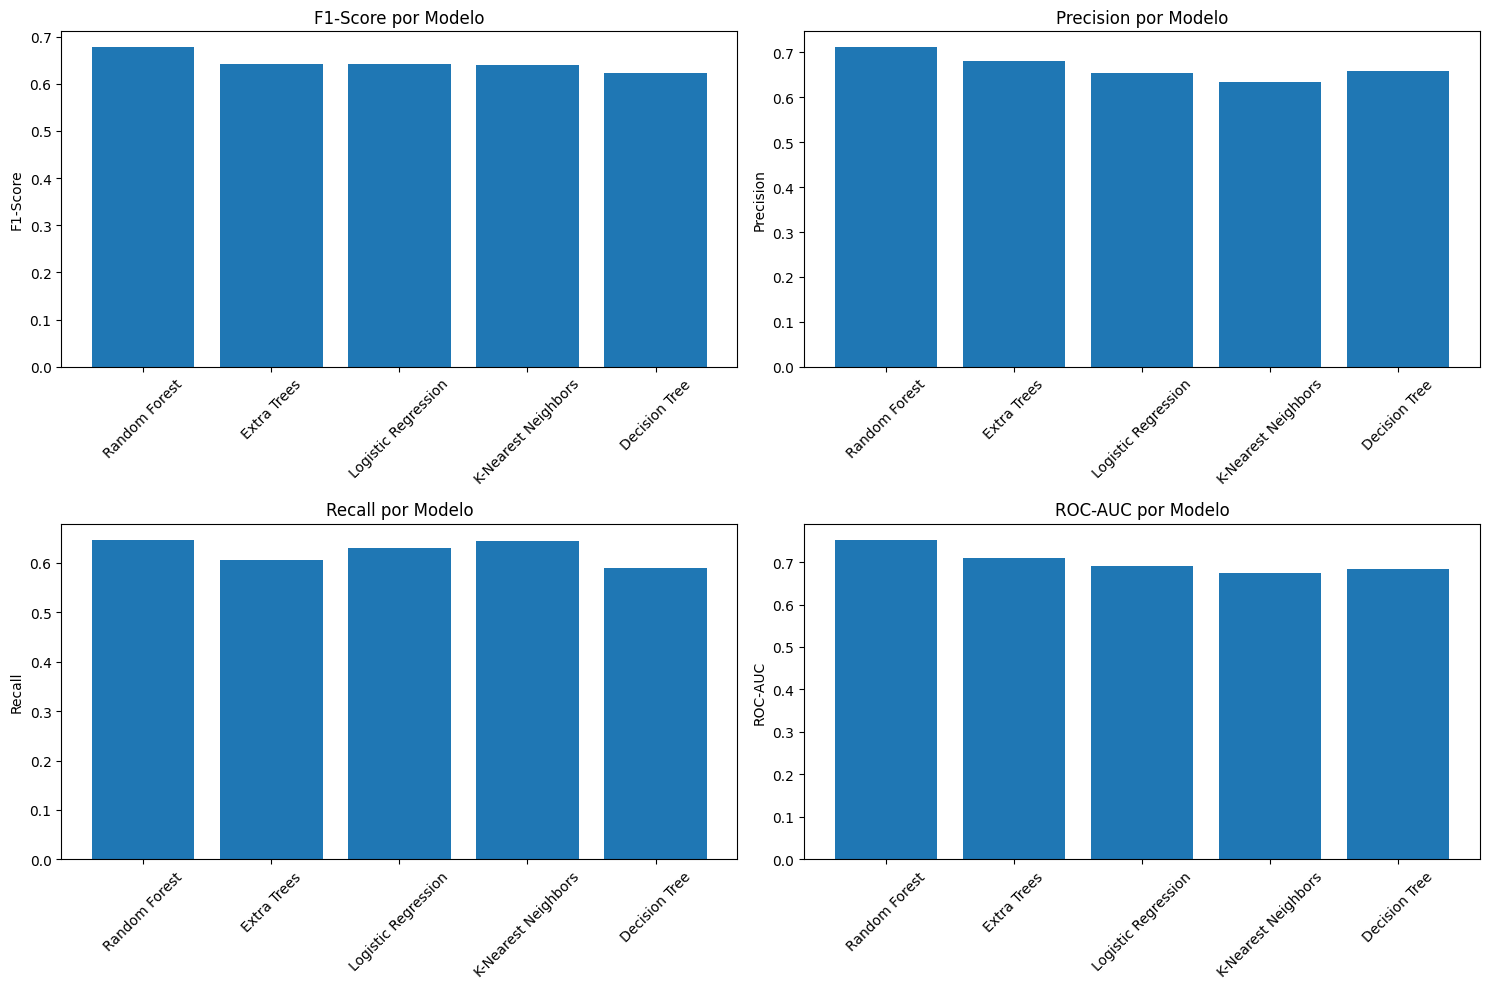

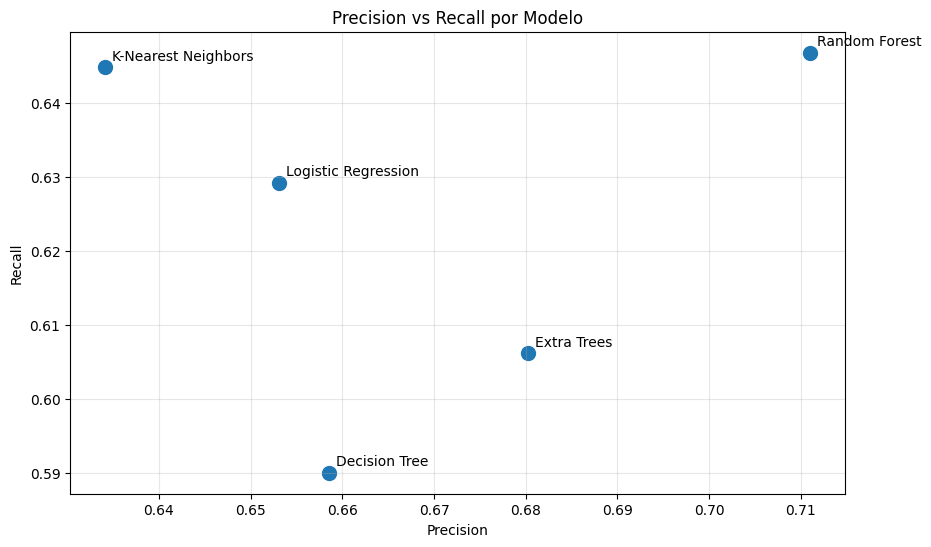

In [17]:
# Gráfico de barras comparativo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# F1-Score
ax1.bar(df_comparacion['Modelo'], df_comparacion['F1-Score'])
ax1.set_title('F1-Score por Modelo')
ax1.set_ylabel('F1-Score')
ax1.tick_params(axis='x', rotation=45)

# Precision
ax2.bar(df_comparacion['Modelo'], df_comparacion['Precision'])
ax2.set_title('Precision por Modelo')
ax2.set_ylabel('Precision')
ax2.tick_params(axis='x', rotation=45)

# Recall
ax3.bar(df_comparacion['Modelo'], df_comparacion['Recall'])
ax3.set_title('Recall por Modelo')
ax3.set_ylabel('Recall')
ax3.tick_params(axis='x', rotation=45)

# ROC-AUC
ax4.bar(df_comparacion['Modelo'], df_comparacion['ROC-AUC'])
ax4.set_title('ROC-AUC por Modelo')
ax4.set_ylabel('ROC-AUC')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Gráfico de dispersión Precision vs Recall
plt.figure(figsize=(10, 6))
plt.scatter(df_comparacion['Precision'], df_comparacion['Recall'], s=100)

for i, row in df_comparacion.iterrows():
    plt.annotate(row['Modelo'], 
                (row['Precision'], row['Recall']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall por Modelo')
plt.grid(True, alpha=0.3)
plt.show()

## Guardar resultados

Voy a guardar todos los resultados para poder usarlos en notebooks posteriores y para tener un registro completo de los experimentos.

In [18]:
# Crear directorio de resultados si no existe
os.makedirs('../models', exist_ok=True)

# Guardar resultados completos
resultados_completos = {
    'timestamp': datetime.now().isoformat(),
    'notebook': '04_modelos_base_tradicionales-winsorizing',
    'descripcion': 'Evaluación de modelos tradicionales de ML',
    'configuracion': {
        'cv_folds': 5,
        'random_state': 42,
        'scoring_principal': 'f1',
        'datos': {
            'n_samples': len(X),
            'n_features': len(X.columns),
            'clase_positiva_prop': float(y.mean())
        }
    },
    'resultados_por_modelo': todos_resultados,
    'tabla_comparacion': df_comparacion.to_dict('records'),
    'mejor_modelo': {
        'nombre': mejor_modelo['Modelo'],
        'f1_score': float(mejor_modelo['F1-Score']),
        'metricas_completas': todos_resultados[mejor_modelo['Modelo']]
    },
    'feature_importance': feature_importance.head(20).to_dict('records')
}

# Guardar como JSON
with open('../models/resultados_modelos_tradicionales-winsorizing.json', 'w') as f:
    json.dump(resultados_completos, f, indent=2)

# Guardar tabla de comparación como CSV
df_comparacion.to_csv('../models/comparacion_modelos_tradicionales-winsorizing.csv', index=False)

# Guardar el mejor modelo entrenado
mejor_modelo_obj = todos_resultados[mejor_modelo['Modelo']]
if mejor_modelo['Modelo'] == 'Random Forest':
    joblib.dump(rf_full, '../models/mejor_modelo_tradicional-winsorizing.pkl')
elif mejor_modelo['Modelo'] == 'Extra Trees':
    et_full = ExtraTreesClassifier(**et_model.get_params())
    et_full.fit(X, y)
    joblib.dump(et_full, '../models/mejor_modelo_tradicional-winsorizing.pkl')
# Agregar otros modelos según sea necesario

print("Resultados guardados:")
print("- ../models/resultados_modelos_tradicionales-winsorizing.json")
print("- ../models/comparacion_modelos_tradicionales-winsorizing.csv")
print("- ../models/mejor_modelo_tradicional-winsorizing.pkl")

print(f"\nMejor modelo: {mejor_modelo['Modelo']} con F1-Score: {mejor_modelo['F1-Score']:.4f}")

Resultados guardados:
- ../models/resultados_modelos_tradicionales-winsorizing.json
- ../models/comparacion_modelos_tradicionales-winsorizing.csv
- ../models/mejor_modelo_tradicional-winsorizing.pkl

Mejor modelo: Random Forest con F1-Score: 0.6773
